In [2]:
## Importing required packages
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage, BaseMessage
from typing import TypedDict, Annotated, Literal

from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_perplexity import ChatPerplexity
from dotenv import load_dotenv

from pydantic import BaseModel, Field
from langgraph.graph import add_messages
import operator

import os
import time

## Libraries to retain memory
from langgraph.checkpoint.memory import InMemorySaver

In [3]:
class FaultState(TypedDict):
    start: str
    step1: str
    step2: str
    step3: str 

In [4]:
def start(state: FaultState) -> FaultState:
    print("Start done")
    return {'start' : 'start done'}

def step1(state: FaultState) -> FaultState:
    print("Step 1 done")
    return {'step1' : 'done'}

def step2(state: FaultState) -> FaultState:
    time.sleep(30)
    print("Step 2 done")
    return {'step2' : 'done'}

def step3(state: FaultState) -> FaultState:
    print("Step 3 done")
    return {'step3' : 'done'}

In [5]:
graph = StateGraph(FaultState)

graph.add_node('start', start)
graph.add_node('step1', step1)
graph.add_node('step2', step2)
graph.add_node('step3', step3)

graph.add_edge(START, 'start')
graph.add_edge('start', 'step1')
graph.add_edge('step1', 'step2')
graph.add_edge('step2', 'step3')
graph.add_edge('step3', END)

checkpoint = InMemorySaver()
workflow = graph.compile(checkpointer= checkpoint)

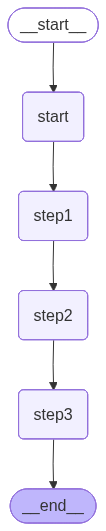

In [6]:
workflow

In [8]:
# Run workflow with config + try/except
try:
    result = workflow.invoke(
        {}, 
        config={"configurable": {"thread_id": "my-workflow-001"}}
    )
except KeyboardInterrupt:
    print("\n⚠️ Workflow interrupted manually!")

Start done
Step 1 done
Step 2 done
Step 3 done


In [9]:
## If you interrupt the graph in between, it will automatically stores the state and we can again invoke the graph then it will resume its invoking where we left off.
workflow.invoke(None, config={"configurable": {"thread_id": "my-workflow-001"}})


{'start': 'start done', 'step1': 'done', 'step2': 'done', 'step3': 'done'}